# Simulation and estimation in a Markov model of breast cancer

* Interpretation of states:
    - 1 : “Disease‑free after surgery”
    - 2 : “Local recurrence”
    - 3 : "Distant metastasis”
    - 4 :  "Local and distant"
    - 5 :  “Death (absorbing)”
* Time step
    - 1 month
* Probability matrix, P
* Initial condition: All 1000 women start in state 1 at month t = 0.
* Stopping criterion: End the simulation as soon as state 5 is reached

 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import matrix_power
from scipy import stats
from scipy.linalg import expm

## Part 1: A discrete-time mode

In [2]:
########## Transition matrix ##########
P = np.array([
    [0.9915, 0.005 , 0.0025, 0.    , 0.001 ],
    [0.    , 0.986 , 0.005 , 0.004 , 0.005 ],
    [0.    , 0.    , 0.992 , 0.003 , 0.005 ],
    [0.    , 0.    , 0.    , 0.991 , 0.009 ],
    [0.    , 0.    , 0.    , 0.    , 1.    ]
])

### Task 1
Questions:
 - Histogram of lifetimes (months alive after surgery)
 - Proportion of women who ever visit state 2 (“cancer reappears locally”)

Mean lifetime: 269.7 months
Median lifetime: 232 months
Std-dev: 187.8 months
Proportion with local recurrence: 0.596


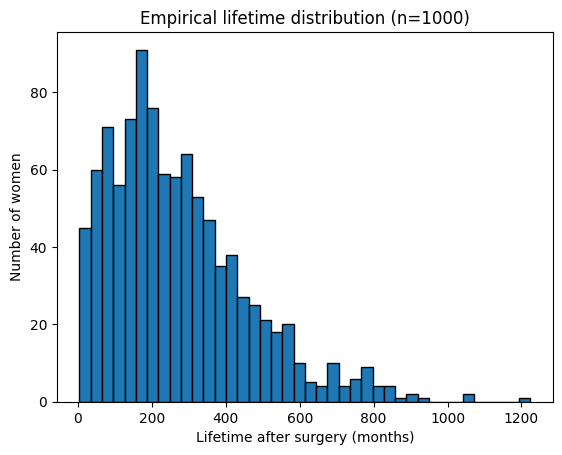

In [3]:

initial_state = 0 # Initial state of each woman X_0 = 1 with 0-index
N_women = 1000 # number of women
# draws from a categorical distribution over possible states 0-indexed
rng = np.random.default_rng(40)


lifetimes = []
state_2 = []


for _ in range(N_women):
    state = initial_state
    months = 0
    seen_state_2 = False

    while state != 4:
        state = rng.choice(5, p=P[state]) # state for 0-indexing. P[state] is the correspnding row with probs. of transitioning from the current state.
        months += 1
        if state == 1: # state 2
            seen_state_2 = True


    lifetimes.append(months)
    state_2.append(seen_state_2)


lifetimes = np.array(lifetimes)
local_recurrences = np.array(state_2)


######## Analysis Task 1 ############
print(f"Mean lifetime: {lifetimes.mean():.1f} months")
print(f"Median lifetime: {np.median(lifetimes):.0f} months")
print(f"Std-dev: {lifetimes.std(ddof=1):.1f} months")
print(f"Proportion with local recurrence: {local_recurrences.mean():.3f}")

plt.hist(lifetimes, bins=40, edgecolor='black')
plt.xlabel("Lifetime after surgery (months)")
plt.ylabel("Number of women")
plt.title("Empirical lifetime distribution (n=1000)")
plt.show()


### Task 2
Let $p_t$ denote the probability distribution over the states at time $t$. This distribution can be found from the following formula: $p_t = p_0(P_t)$.

In [4]:
######## Simulate empirical dist of states for t = 120 ##########

N = 1000  # number of simulations (bigger N -> smaller monte carlo error)
states_count = np.zeros(5, dtype=int)
rng = np.random.default_rng(40)

for _ in range(N):
    state = 0
    for _ in range(120): ## t = 120 months
        state = rng.choice(5, p=P[state])
    states_count[state] += 1
empirical_dist_120 = states_count / N

print("Empirical distribution of states at t = 120 months:, \n", empirical_dist_120)

######## Calculate theretical dist of states for t = 120 ##########
p0 = np.array([1,0,0,0,0])
theoretical_dist = p0 @ matrix_power(P, 120)

print("Theoretical distribution of states at t = 120 months:, \n", theoretical_dist)

######### Chi-squared test ##########
chi2, p_value = stats.chisquare(states_count, N*theoretical_dist)
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis with p-value:", p_value)
else:
    print("Fail to reject the null hypothesis with p-value:", p_value)

Empirical distribution of states at t = 120 months:, 
 [0.372 0.146 0.171 0.083 0.228]
Theoretical distribution of states at t = 120 months:, 
 [0.35902627 0.15895604 0.1660869  0.06774149 0.2481893 ]
Fail to reject the null hypothesis with p-value: 0.14973844105073003


### Task 3
It can be shown that the lifetime, T, follows a so-called discrete phase-type distribution. This distribution has probability mass function $P(T = t) = \pi(P_s)^tp_s$. And mean $E(T) = \pi(I − P_s)^{−1}1$. Where:
 - $\pi$ is the distribution over states 1, 2, 3, 4 at t = 0.
 - $P_s$ is a 4 × 4 sub-matrix of $P$ formed by removing the last row and column. 
 - $p_s$ is column vector indicating the probability of dying from states 1, 2, 3, 4. 
 - 1 is a vector of ones of appropriate dimension.

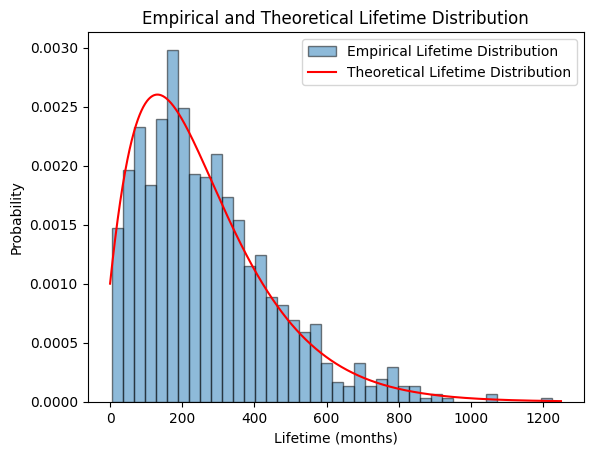

In [6]:
########### Theoretical lifetime distribution ##########

Ps = P[:4, :4] #submatrix excluding dying state
ps = P[:4, 4] #transition probabilities to dying
pi = np.array([1,0,0,0]) # initial distribution of states, all women in state 1


t_max = 1250
pmf_lifetime = np.empty(t_max)
for t in range(t_max):
    pmf_lifetime[t] = pi @ matrix_power(Ps, t) @ ps
pmf_lifetime /= pmf_lifetime.sum()
cdf_lifetime = np.cumsum(pmf_lifetime)

def theo_cdf_lifetimes(t):
    # floor to integer months, map k→index k−1
    k = np.floor(t).astype(int)
    idx = k - 1
    # clip so idx<0 → 0.0 and idx>=t_max → 1.0
    idx = np.clip(idx, -1, t_max-1)
    return np.where(idx < 0, 0.0, cdf[idx])



plt.hist(lifetimes, bins=40, density=True, alpha=0.5, edgecolor='black', label='Empirical Lifetime Distribution')
plt.plot(np.arange(t_max), pmf_lifetime, color='red', label='Theoretical Lifetime Distribution')
plt.legend()
plt.xlabel("Lifetime (months)")
plt.ylabel("Probability")
plt.title("Empirical and Theoretical Lifetime Distribution")
plt.show()



In [7]:
# Define bin edges (e.g., 25 bins of 50 months each to cover up to 1250 months)
bins = np.arange(0, 1251, 50)

# Compute observed frequencies from simulated lifetimes
observed_freq, _ = np.histogram(lifetimes, bins=bins)

# Compute expected frequencies from theoretical PMF
expected_freq = []
for i in range(len(bins) - 1):
    lower, upper = bins[i], bins[i+1]
    expected = np.sum(pmf_lifetime[lower:upper]) * len(lifetimes)
    expected_freq.append(expected)
expected_freq = np.array(expected_freq)

# Perform chi-squared test
chi2_stat, p_val = stats.chisquare(f_obs=observed_freq, f_exp=expected_freq)

# Print results
print("Chi-squared test statistic:", chi2_stat)
print("p-value:", p_val)

Chi-squared test statistic: 30.007209315461512
p-value: 0.18451297050983106


### Task 4

Estimate the expected lifetime, after surgery, of a woman who survives the
first 12 months following surgery, but whose breast cancer has also reappeared within the first 12 months, either locally or distant.
Hint: Use rejection sampling. Simulate a number of women, and discard
all simulations that do not meet the requirements. Do this until you have
reached 1000 acceptable simulations.

In [7]:
initial_state = 0
N_accepted_women = 1000
rng = np.random.default_rng(40)

accepted_lifetimes = []
n_trials = 0   # total women simulated

while len(accepted_lifetimes) < N_accepted_women:
    n_trials += 1 

    # simulate first months 1–12
    state      = initial_state
    recurred   = False
    survived12 = True

    for month in range(1, 13):
        state = rng.choice(5, p=P[state])
        if state == 4:
            survived12 = False
            break
        if state in (1,2,3):
            recurred = True

    # reject unless both hold
    if not (survived12 and recurred):
        continue

    # finish to death
    months = 12
    while state != 4:
        state  = rng.choice(5, p=P[state])
        months += 1

    accepted_lifetimes.append(months)

n_accepted = len(accepted_lifetimes)
n_rejected = n_trials - n_accepted
print(f"Simulated {n_trials:,} women to get {n_accepted} accepted.")
print(f"Rejected {n_rejected:,} women (i.e. didn't survive+recur by 12m).")
#Expected lifetime of accepted women
expected_lifetime = np.mean(accepted_lifetimes)
print(f"Expected lifetime of accepted women: {expected_lifetime:.1f} months")
# Calculate 95% confidence interval for the expected lifetime
se_lifetime = np.std(accepted_lifetimes, ddof=1) / np.sqrt(n_accepted)
ci_lower = expected_lifetime - 1.96 * se_lifetime
ci_upper = expected_lifetime + 1.96 * se_lifetime
print(f"95% Confidence interval for expected lifetime: ({ci_lower:.1f}, {ci_upper:.1f}) months")

Simulated 11,683 women to get 1000 accepted.
Rejected 10,683 women (i.e. didn't survive+recur by 12m).
Expected lifetime of accepted women: 183.1 months
95% Confidence interval for expected lifetime: (174.0, 192.2) months


### Task 5

What fraction of women die within the first 350 months? Answer this by simulating 200 women, and record the fraction. Do this 100 times. Use control variates to reduce the variance. How large a reduction in variance do you see, using control variates, as opposed to the crude Monte Carlo estimator? Hint: Use the mean lifetime after surgery of the 200 simulations as the control variate.

In [53]:
repeats = 100
N_women = 200

initial_state = 0
rng = np.random.default_rng(40)
lifetime350_fraction = []
control_variate = [] # contral variate


for _ in range(repeats):
    lifetimes = []
    for _ in range(N_women):
        state = initial_state
        months = 0

        while state != 4:
            state = rng.choice(5, p=P[state]) # state for 0-indexing. P[state] is the correspnding row with probs. of transitioning from the current state.
            months += 1
        lifetimes.append(months)
    
    lifetimes = np.array(lifetimes)
    lifetime350_fraction.append(np.sum(lifetimes <= 350)/N_women)
    control_variate.append(np.mean(lifetimes))



### Result of experiment with control variate ###

lifetime350_fraction = np.asarray(lifetime350_fraction)
control_variate = np.asarray(control_variate)
# Empirical covariance
cov = np.cov(lifetime350_fraction, control_variate, ddof=1)
# control variate adjustment
c_star = -cov[0,1] / cov[1,1]
fraction_cv = lifetime350_fraction + c_star * (control_variate - control_variate.mean())

######## Compare estimators ######## 

# Crude Monte Carlo estimator
mean_crude = lifetime350_fraction.mean()
var_crude = lifetime350_fraction.var(ddof=1)

## Control variate estimator
mean_cv = fraction_cv.mean()
var_cv = fraction_cv.var(ddof=1)

percent_reduction = 100 * (1 - var_cv / var_crude)

print(f"Crude estimator:")
print(f"  mean = {mean_crude:.4f},  variance = {var_crude:.6e}")

print(f"Control-variate estimator:")
print(f" mean = {mean_cv:.4f},  variance = {var_cv:.6e}")
print(f"Variance reduction = {percent_reduction:.1f}%")


Crude estimator:
  mean = 0.7431,  variance = 9.185126e-04
Control-variate estimator:
  mean = 0.7432,  variance = 3.985151e-04
Variance reduction = 56.6%


### Task 6
What assumptions underlie the discrete tome Markov chain model? Are those assumpitions realistifc? How may we relax some of these assumptions, possibly at the cost of increased model complexity?

 - The Markov property makes it so that the future depends only on the current state, not on how long the patient has already spent there, i.e. once a woman is in “distant metastasis” (state 3), the same row of P is used whether she entered 1 month or 5 years ago, which probably should indicate a higher risk. In addition, we have a fixed one-month step: all events are rounded to month-ends and multiple events inside one month are collapsed into one transition. However, transitions may occur at any time. Furthermore, there’s no covariates, maybe such as age which could affect the transition probabilities. Relaxations of these assumptions would increase model complexities.

## Part 2: A continuous-time model

### Task 7

In [8]:
##Rate matrix Q
Q = np.array([
    [-0.0085,  0.005,  0.0025,  0, 0.001],
    [0.0,   -0.014,  0.005, 0.004,  0.005],
    [0.0,    0.0,  -0.008,  0.003,  0.005],
    [0.0,    0.0,   0.0,  -0.009,  0.009],
    [0.0,    0.0,   0.0,   0.0,   0.0 ]
])

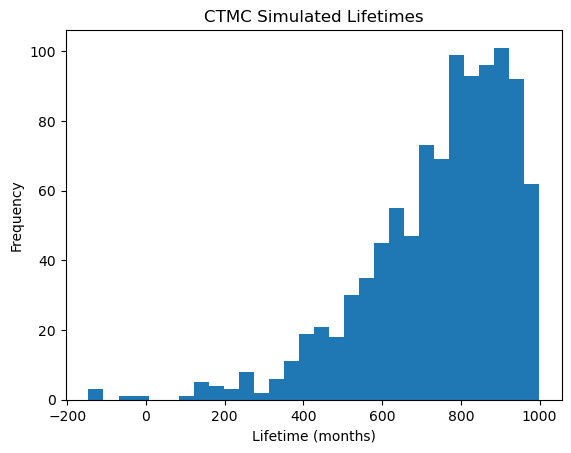

Mean lifetime = 253.92 months (95% CI: 242.42, 265.41)
SD of lifetime = 185.44 months (95% CI: 177.65, 193.94)
Proportion metastasized by 30.5 mo = 0.361 (95% CI: 0.331, 0.391)


In [ ]:
from scipy.stats import chi2

def simulate_ctmc(Q, n_paths, metastasis_time=30.5):
    n_states = Q.shape[0]
    lifetimes = np.zeros(n_paths)
    metastasis_flags = np.zeros(n_paths, dtype=int)
    
    for k in range(n_paths):
        t = 0.0
        current = 0  # start in state 1 (index 0)
        hit_metastasis = False
        
        while current != n_states-1:  # until death (last index)
            rates = Q[current, :]
            exit_rate = -rates[current]
            # sample holding time
            tau = np.random.exponential(1/exit_rate)
            t_next = t + tau
            
            # check metastasis by metastasis_time
            if not hit_metastasis and t < metastasis_time <= t_next:
                # if jump lands in state 3 (idx 2) or 4 (idx 3)
                probs = rates.copy()
                probs[current] = 0
                probs = probs / exit_rate
                chosen = np.random.choice(n_states, p=probs)
                if chosen in {2, 3}:
                    hit_metastasis = True
            
            # advance time and state
            t = t_next
            probs = rates.copy()
            probs[current] = 0
            probs = probs / exit_rate
            current = np.random.choice(n_states, p=probs)
            
            # record if already in metastasis at discrete step
            if not hit_metastasis and current in {2, 3} and t <= metastasis_time:
                hit_metastasis = True
        
        lifetimes[k] = t
        metastasis_flags[k] = int(hit_metastasis)
    
    return lifetimes, metastasis_flags

# Simulate 1000 trajectories
n_sim = 1000
lifetimes, flags = simulate_ctmc(Q, n_sim)
# 1. Histogram of lifetimes
plt.hist(alivetime, bins=30)
plt.xlabel("Lifetime (months)")
plt.ylabel("Frequency")
plt.title("CTMC Simulated Lifetimes")
plt.show()

# 2. Mean, SD, and 95% CIs
mean_lt = lifetimes.mean()
sd_lt = lifetimes.std(ddof=1)
se_mean = sd_lt / np.sqrt(n_sim)
ci_mean = (mean_lt - 1.96*se_mean, mean_lt + 1.96*se_mean)

# CI for SD using chi-square
alpha = 0.05
ci_sd = (
    sd_lt * np.sqrt((n_sim-1)/chi2.ppf(1-alpha/2, n_sim-1)),
    sd_lt * np.sqrt((n_sim-1)/chi2.ppf(alpha/2, n_sim-1))
)

print(f"Mean lifetime = {mean_lt:.2f} months (95% CI: {ci_mean[0]:.2f}, {ci_mean[1]:.2f})")
print(f"SD of lifetime = {sd_lt:.2f} months (95% CI: {ci_sd[0]:.2f}, {ci_sd[1]:.2f})")

# 3. Proportion with metastasis by 30.5 months
p_hat = flags.mean()
se_p = np.sqrt(p_hat*(1-p_hat)/n_sim)
ci_p = (p_hat - 1.96*se_p, p_hat + 1.96*se_p)
print(f"Proportion metastasized by 30.5 mo = {p_hat:.3f} (95% CI: {ci_p[0]:.3f}, {ci_p[1]:.3f})")


array([-9.35454823e+01, -1.41367587e+02, -1.57426299e+02,  1.43529353e+01,
       -2.04085593e+02, -6.27240837e+02, -1.93663377e+02, -2.06459642e+02,
       -6.60456261e+02, -3.72543475e+02, -1.29225137e+02, -6.33569022e+01,
       -2.74165200e+01, -3.93352851e+02, -3.27786393e+02, -1.16692543e+02,
       -4.45299634e+01, -1.41748149e+02, -9.13668764e+01, -1.48285935e+02,
       -2.18233939e+01, -2.21484934e+02, -1.56300501e+02,  2.61164043e+01,
       -6.15279477e+02, -1.85191138e+02, -8.26848954e+01, -4.60089252e+01,
       -5.98391924e+01, -4.53932102e+01, -6.25293084e+01, -3.61065187e+02,
       -7.78632828e+01, -1.22888735e+02, -5.56403312e+02, -1.95360538e+02,
       -1.83424622e+02, -1.03719466e+02, -1.48460959e+02, -3.82920006e+02,
       -2.92725899e+02, -3.04371668e+02, -2.83008359e+02, -1.48219608e+02,
       -2.46645392e+02, -4.11061603e+02, -1.55248288e+02, -2.66711653e+02,
       -1.97297530e+02, -3.79284809e+02, -2.73738770e+01, -1.27511539e+02,
       -1.07317461e+02, -

Part 8

KS statistic: 0.0265, p‑value: 0.4772


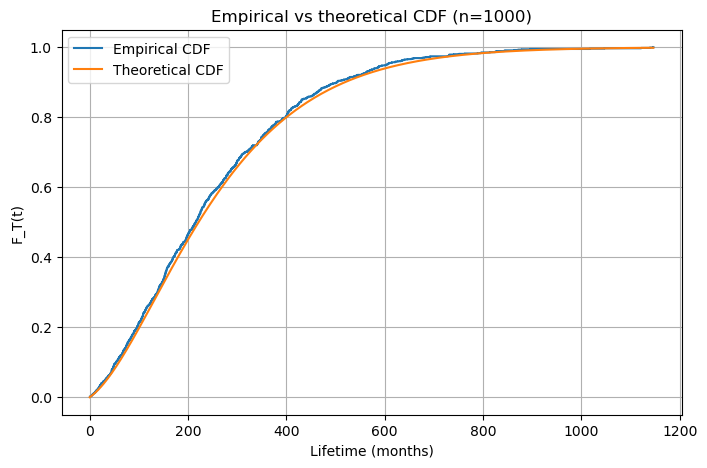

In [39]:

Q_s = Q[:-1, :-1]
ones = np.ones(4)
p0 = np.array([1,0,0,0])

def F_t(t):
    return 1 - (p0 @ expm(Q_s*t) @ ones)

ks_stat, p_val = stats.kstest(lifetimes, np.vectorize(F_t))
print(f"KS statistic: {ks_stat:.4f}, p‑value: {p_val:.4f}")

sorted_life = np.sort(lifetimes)
emp_cdf = np.arange(1, n_sim+1)/n_sim
t_grid = np.linspace(0, sorted_life[-1], 400)
F_values = [F_t(tt) for tt in t_grid]

plt.figure(figsize=(8,5))
plt.step(sorted_life, emp_cdf, where='post', label='Empirical CDF')
plt.plot(t_grid, F_values, label='Theoretical CDF')
plt.xlabel('Lifetime (months)')
plt.ylabel('F_T(t)')
plt.title('Empirical vs theoretical CDF (n=1000)')
plt.legend()
plt.grid(True)
plt.show()

9.

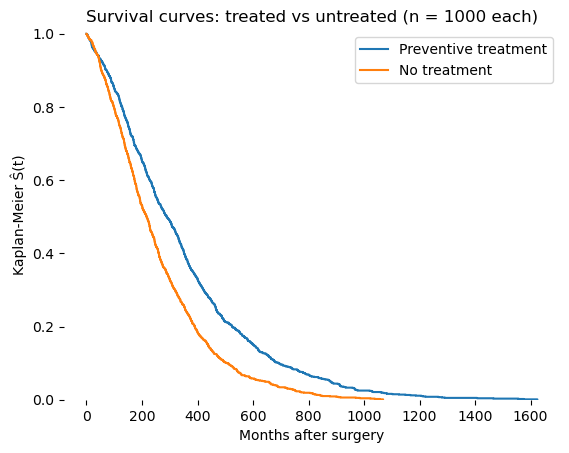

In [29]:
#preventive-treatment matrix  Q (fill * with negatives such that the rows sum to 0)
Q_trt = np.array([
    [-0.00475, 0.0025 , 0.00125, 0.    , 0.001 ],
    [ 0.    , -0.007 , 0.     , 0.002 , 0.005 ],
    [ 0.    ,  0.    , -0.008 , 0.003 , 0.005 ],
    [ 0.    ,  0.    , 0.    , -0.009 , 0.009 ],
    [ 0.    ,  0.    , 0.    , 0.    , 0.    ]
])

Q_untrt = np.array([
    [-0.0085,  0.005,   0.0025, 0,       0.001],
    [0,       -0.014,   0.005,  0.004,   0.005],
    [0,        0,      -0.008,  0.003,   0.005],
    [0,        0,       0,     -0.009,   0.009],
    [0,        0,       0,      0,       0    ]
])

rng = np.random.default_rng(seed=42)

def simulate_lifetime(Q, rng):
    """simulate one woman's lifetime (months) with treatment matrix Q"""

    #initial conditions
    state, t = 0, 0.0 # initial state is 1

    while state != 4:
        rate = -Q[state, state]
        t += rng.exponential(1 / rate) # exponential waiting time
        probs = Q[state].copy();  probs[state] = 0 # transition probabilitie, has to enter new state
        probs = - (probs / Q[state, state])
        state = rng.choice(5, p=probs)
    return t

N = 1_000
lifetimes_trt  = np.array([simulate_lifetime(Q_trt , rng) for _ in range(N)])
lifetimes_untr = np.array([simulate_lifetime(Q_untrt, rng) for _ in range(N)])

def km_step(lifetimes):
    """plotting KM curve"""
    times = np.sort(lifetimes)
    n = len(times)
    alive = n - np.arange(1, n+1) # survivors just after each death
    S_hat = alive / n
    # prepend t=0, S=1 to start the step plot
    x = np.concatenate(([0],  times))
    y = np.concatenate(([1.0], S_hat))
    return x, y

x_trt , y_trt  = km_step(lifetimes_trt)
x_untr, y_untr = km_step(lifetimes_untr)

#plot
plt.step(x_trt , y_trt , where='post', label='Preventive treatment')
plt.step(x_untr, y_untr, where='post', label='No treatment')
plt.xlabel('Months after surgery');  plt.ylabel('Kaplan-Meier Ŝ(t)')
plt.title('Survival curves: treated vs untreated (n = 1000 each)')
plt.legend();  plt.ylim(0, 1.01);  plt.grid(alpha=.3)
plt.box(False)
plt.grid(False)
plt.savefig('Figures/9-Survival.png', dpi = 300)
plt.show()

10.

In [31]:
from lifelines.statistics import logrank_test

# lifetimes_trt  and lifetimes_untr  were produced in Task 9
res = logrank_test(lifetimes_trt, lifetimes_untr)   # no censoring arguments needed
print(f"log-rank χ² = {res.test_statistic:.3f},  p-value = {res.p_value}")

log-rank χ² = 79.525,  p-value = 4.761889095151023e-19
